### Gathering JWST Filter Magnitude Data

In [682]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
from flystar import starlists, transforms, startables, align
from collections import Counter
from scipy.spatial import cKDTree as KDT
from astropy.table import Column, Table
import matplotlib.gridspec as gridspec
import itertools
import copy
import scipy.signal
from scipy.spatial import distance
import math
import pdb
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import sys
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import pdb

df = pd.read_csv("catalog115w.csv", delimiter = " ")
df.to_csv('catalog115t.csv', encoding = 'utf-8', index = False)
df2 = pd.read_csv("catalog212n.csv", delimiter = " ")
df2.to_csv('catalog212t.csv', encoding = 'utf-8', index = False)

#coordinates
x1 = df['xcentroid']
y1 = df['ycentroid']
m1 = df['aper30_vegamag']
x2 = df2['xcentroid']
y2 = df2['ycentroid']

#magnitudes
m2 = df2['aper30_vegamag']
m150 = df['aper50_vegamag']
m170 = df['aper70_vegamag']
m250 = df2['aper50_vegamag']
m270 = df2['aper70_vegamag']
m1_total = df['aper_total_vegamag']
m2_total = df2['aper_total_vegamag']

In [683]:
"""
Finds matches between two different catalogs. No transformations are done and it
is assumed that the two catalogs are already on the same coordinate system
and magnitude system.

For two stars to be matched, they must be within a specified radius (dr_tol) and
delta-magnitude (dm_tol). For stars with more than 1 neighbor (within the tolerances),
if one is found that is the best match in both brightness and positional offsets
(closest in both), then the match is made. Otherwise,
their is a conflict and no match is returned for the star.


Parameters
x1 : array-like
    X coordinate in the first catalog
y1 : array-like
    Y coordinate in the first catalog (shape of array must match `x1`)
m1 : array-like
    Magnitude in the first catalog. Must have the same shape as x1.
x2 : array-like
    X coordinate in the second catalog
y2 : array-like
    Y coordinate in the second catalog (shape of array must match `x2`)
m2 : array-like
    Magnitude in the second catalog. Must have the same shape as x2.
dr_tol : float
    How close (in units of the first catalog) a match has to be to count as a match.
    For stars with more than one nearest neighbor, the delta-magnitude is checked
    and the closest in delta-mag is chosen.
dm_tol : float or None, optional
    How close in delta-magnitude a match has to be to count as a match.
    If None, then any delta-magnitude is allowed.
verbose : bool or int, optional
    Prints on screen information on the matching. Higher verbose values 
    (up to 9) provide more detail.

Returns
-------
idx1 : int array
    Indicies into the first catalog of the matches. Will never be
    larger than `x1`/`y1`.
idx2 : int array
    Indicies into the second catalog of the matches. Will never be
    larger than `x1`/`y1`.
dr : float array
    Distance between the matches.
dm : float array
    Delta-mag between the matches. (m1 - m2) 
"""
 

dr_tol = 15
dm_tol = 15
verbose = False
x1 = np.array(x1, copy=False)
y1 = np.array(y1, copy=False)
m1 = np.array(m1, copy=False)
x2 = np.array(x2, copy=False)
y2 = np.array(y2, copy=False)
m2 = np.array(m2, copy=False)

if x1.shape != y1.shape:
    raise ValueError('x1 and y1 do not match!')
if x2.shape != y2.shape:
    raise ValueError('x2 and y2 do not match!')

coords1 = np.empty((x1.size, 2))
coords1[:, 0] = x1
coords1[:, 1] = y1

coords2 = np.empty((x2.size, 2))
coords2[:, 0] = x2
coords2[:, 1] = y2

idxs1 = np.ones(x1.size, dtype=int) * -1
idxs2 = np.ones(x1.size, dtype=int) * -1

kdt = KDT(coords2, balanced_tree=False)

i2_match = kdt.query_ball_point(coords1, dr_tol)
Nmatch = np.array([len(idxs) for idxs in i2_match])

Nmatch_max = Nmatch.max()

for nn in range(1, Nmatch_max+1):
    i1_nn = np.where(Nmatch == nn)[0]

    if len(i1_nn) == 0:
        continue

    if nn == 1:
        i2_nn = np.array([i2_match[mm][0] for mm in i1_nn])
        if dm_tol != None:
            dm = np.abs(m1[i1_nn] - m2[i2_nn])
            keep = dm < dm_tol
            idxs1[i1_nn[keep]] = i1_nn[keep]
            idxs2[i1_nn[keep]] = i2_nn[keep]
        else:
            idxs1[i1_nn] = i1_nn
            idxs2[i1_nn] = i2_nn
    else:
        i2_tmp = np.array([i2_match[mm] for mm in i1_nn])

        x1_nn = np.tile(x1[i1_nn], (nn, 1)).T
        y1_nn = np.tile(y1[i1_nn], (nn, 1)).T
        m1_nn = np.tile(m1[i1_nn], (nn, 1)).T

        x2_nn = x2[i2_tmp]
        y2_nn = y2[i2_tmp]
        m2_nn = m2[i2_tmp]
        dr = np.abs(x1_nn - x2_nn, y1_nn - y2_nn)
        dm = np.abs(m1_nn - m2_nn)

        if dm_tol != None:
            dr_msk = np.ma.masked_where(dm > dm_tol, dr)
            dm_msk = np.ma.masked_where(dm > dm_tol, dm)

            dm_min = dm_msk.argmin(axis=1)
            dr_min = dr_msk.argmin(axis=1)

            dm_tmp = np.array([dm.T[dm_min[I]][I] for I in np.lib.index_tricks.ndindex(dm_min.shape)])

            keep = (dm_min == dr_min) & (dm_tmp < dm_tol)
        else:
            dm_min = dm.argmin(axis=1)
            dr_min = dr.argmin(axis=1)

            keep = (dm_min == dr_min)

        i2_keep_2D = i2_tmp[keep]
        dr_keep = dr_min[keep]  
        ii_keep = np.arange(len(dr_keep)) 

        idxs1[i1_nn[keep]] = i1_nn[keep]
        idxs2[i1_nn[keep]] = i2_keep_2D[ii_keep, dr_keep]

idxs1 = idxs1[idxs1 >= 0]
idxs2 = idxs2[idxs2 >= 0]

dr = np.hypot(x1[idxs1] - x2[idxs2], y1[idxs1] - y2[idxs2])
dm = m1[idxs1] - m2[idxs2]
dm50 = m150[idxs1] - m250[idxs2]
dm70 = m170[idxs1] - m270[idxs2]
dm_tot = m1_total[idxs1] - m2_total[idxs2]

duplicates = [item for item, count in list(Counter(idxs2).items()) if count > 1]
if verbose > 2:
    print(( 'Found {0:d} duplicates out of {1:d} matches'.format(len(duplicates), len(dm))))
keep = np.ones(len(idxs1), dtype=bool)
for dd in range(len(duplicates)):

    dups = np.where(idxs2 == duplicates[dd])[0]

    keep[dups] = False

    dm_dups = m1[idxs1[dups]] - m2[idxs2[dups]]
    dr_dups = np.hypot(x1[idxs1[dups]] - x2[idxs2[dups]], y1[idxs1[dups]] - y2[idxs2[dups]])

    dm_min = np.abs(dm_dups).argmin()
    dr_min = np.abs(dr_dups).argmin()

    if dm_min == dr_min:
        keep[dups[dm_min]] = True
    else:
        if verbose:
            print('confused, dropping')
            
idxs1 = idxs1[keep]
idxs2 = idxs2[keep]
dr = dr[keep]
dm = dm[keep]

### Base JWST CMD - F115w - F212n vs. F115w

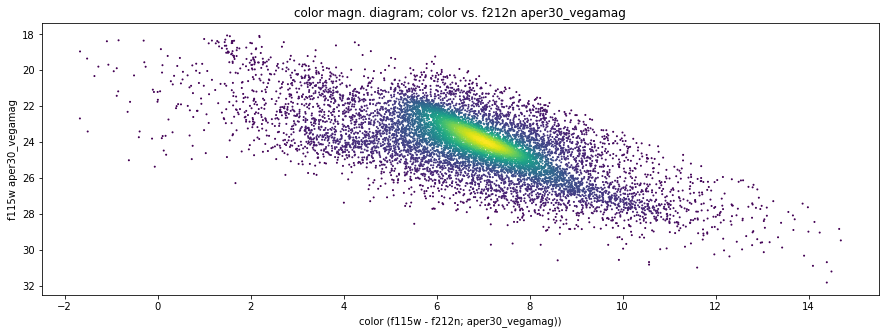

In [684]:
from scipy.stats import gaussian_kde

arr_m2 = []
arr_m1 = []

for i in idxs2: 
    arr_m2 = arr_m2 + [m2[i]]
for i in idxs1: 
    arr_m1 = arr_m1 + [m1[i]]

arr_diff = np.subtract(arr_m1, arr_m2) 
figure, axis = plt.subplots(1, figsize=(15,5))


xy = np.vstack([arr_diff, arr_m1])
z = gaussian_kde(xy)(xy)

axis.set_title('color magn. diagram; color vs. f212n aper30_vegamag')
axis.scatter(arr_diff, arr_m1, c=z, s=1)
plt.ylabel('f115w aper30_vegamag')
plt.xlabel('color (f115w - f212n; aper30_vegamag))')
plt.gca().invert_yaxis()

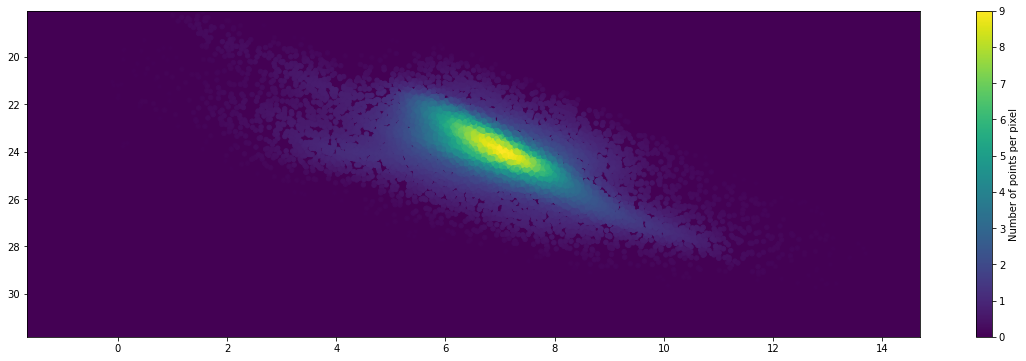

In [710]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1,projection='scatter_density')
    density = ax.scatter_density(x, y)
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure(figsize = (20,6))
using_mpl_scatter_density(fig, arr_diff, arr_m1)
plt.scatter(arr_diff, arr_m1, c=z, s=20)
plt.gca().invert_yaxis()
plt.show()

### Establishing Stellar Isochrone Parameters & Generating Points

In [686]:
logAge      = np.log10(10**6.) # Age in log(years)
AKs         = 2.5   # extinction in mags
dist        = 8000 # distance in parsec
metallicity = -0.1 # Metallicity in [M/H]

evo_model = evolution.MISTv1() 
atm_func  = atmospheres.get_merged_atmosphere
red_law   = reddening.RedLawPowerLaw(2.03, 2.16, wave_min=0.9, wave_max=10.0)

filt_list = ['jwst,F212N', 'jwst,F115W']

iso_dir = '/Users/devaldeliwala/Desktop/isochrone.fits'


my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity,
                                    evo_model=evo_model, atm_func=atm_func,
                                    red_law=red_law, filters=filt_list,
                                    iso_dir=iso_dir)

print(my_iso.points)

          L                   Teff        ...    m_jwst_F115W   
          W                    K          ...                   
---------------------- ------------------ ... ------------------
2.5755960188202456e+25  2969.516698836625 ... 28.948743911398395
2.6060207902049794e+25  2971.509325646466 ... 28.936393511743237
 2.775296761823791e+25  2982.292493371955 ... 28.870295914724032
 2.953484576901966e+25 2993.1069191838255 ... 28.805080915891544
 3.141077710972164e+25 3003.9461176406967 ...  28.74053636560799
3.3385305555453767e+25 3014.7989693176296 ... 28.676518275304357
 3.546381437969777e+25   3025.65892039698 ... 28.613226398216316
                   ...                ... ...                ...
 7.892653788126548e+32  54901.22427227391 ... 17.619822961958608
  8.46313242441269e+32  55152.19969412832 ... 17.563860847306188
 8.871573136095877e+32  55263.45506003409 ... 17.521439044254585
 9.633018013707597e+32 55310.982886988066 ... 17.435768132159495
1.1157035005739054e+33  5

In [701]:
print(my_iso.points.meta)
print('The columns in the isochrone table are: {0}'.format(my_iso.points.keys()))

OrderedDict([('REDLAW', 'pl,2.03,2.16,0.9,10.0'), ('ATMFUNC', 'get_merged_atmosphere'), ('EVOMODEL', 'MISTv1'), ('LOGAGE', 6.0), ('AKS', 2.5), ('DISTANCE', 8000), ('METAL_IN', -0.1), ('METAL_ACT', -0.00616030870481844), ('WAVEMIN', 3000), ('WAVEMAX', 52000)])
The columns in the isochrone table are: ['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'mass_current', 'phase', 'm_jwst_F212N', 'm_jwst_F115W']


In [702]:
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f115W = np.round(my_iso.points[idx[0]]['m_jwst_F115W'], decimals=3)
f212N = np.round(my_iso.points[idx[0]]['m_jwst_F212N'], decimals=3)

print('1 M_sun: F115W = {0} mag, F212n = {1} mag'.format(f115W, f212N))

1 M_sun: F115W = 25.737 mag, F212n = 18.895 mag


### Plotting Isochrone over base JWST CMD 
##### F115W & F212n filter catalogs have greatly differing magnitudes -- unable to 

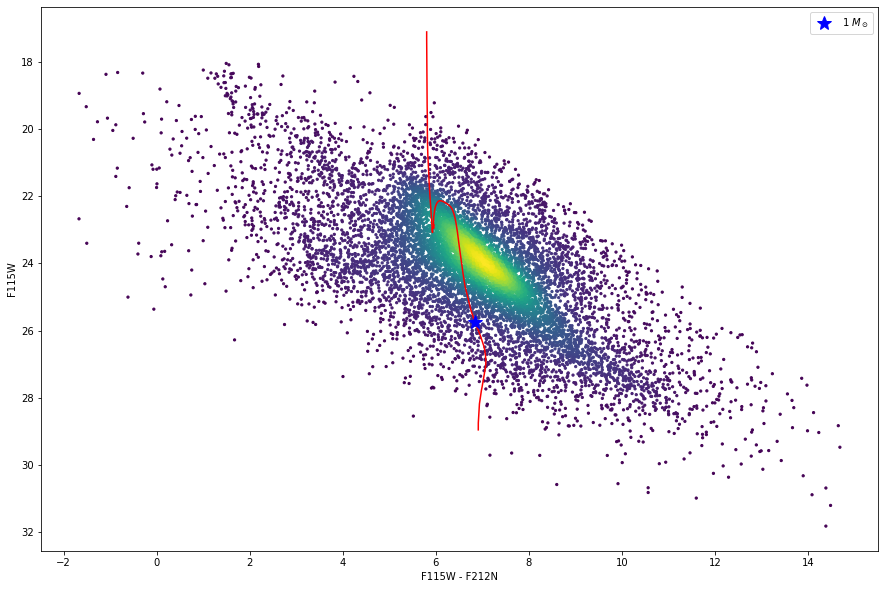

In [690]:
py.figure(1, figsize=(15,10))
py.clf()
py.plot(my_iso.points['m_jwst_F115W'] - my_iso.points['m_jwst_F212N'], 
       my_iso.points['m_jwst_F115W'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_jwst_F115W'][idx] - my_iso.points['m_jwst_F212N'][idx], 
       my_iso.points['m_jwst_F115W'][idx], 'b*', ms=15, label='1 $M_\odot$')
py.xlabel('F115W - F212N')
py.ylabel('F115W')
py.gca().invert_yaxis()
py.legend()

py.scatter(arr_diff, arr_m1, c=z, s=5)
py.show()
#py.ylabel('f115w aper30_vegamag')
#py.xlabel('color (f115w - f212n; aper30_vegamag))')

In [691]:
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01

# NOTE: when defining the power law slope for each segment of the IMF, we define
# the entire exponent, including the negative sign. For example, if dN/dm $\propto$ m^-alpha,
# then you would use the value "-2.3" to specify an IMF with alpha = 2.3. 

massLimits = np.array([0.2, 0.5, 1, 120])                        # Define boundaries of each mass segement
powers = np.array([-1.3, -2.3, -2.3])                            # Power law slope associated with each mass segment
my_imf = imf.IMF_broken_powerlaw(massLimits, powers, imf_multi)

In [692]:
mass = 10**5.
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

In [693]:
print(cluster.star_systems)

        mass        isMultiple ...    m_jwst_F115W    N_companions
------------------- ---------- ... ------------------ ------------
  0.314571290071844       True ... 26.742035727959536            1
   0.22310622234432      False ...  27.67585905422706            0
 3.5803207309111413      False ...  22.37074285077366            0
0.23811914196057518      False ... 27.609243180809308            0
  2.657030862949936       True ...  23.50176061114171            1
 0.6184890816505587      False ... 26.485943766324603            0
 0.5460003287402605      False ...  26.66463560533528            0
                ...        ... ...                ...          ...
0.25721419479514007      False ...  27.53084518847272            0
 0.2158149659022733      False ... 27.709212757894736            0
0.20617221646617878      False ... 27.752000444731042            0
 0.3269870785784999      False ...  27.27333316489427            0
 0.6316283809201468      False ... 26.454916174587954         

In [703]:
print('The cluster table contains these columns: {0}'.format(cluster.star_systems.keys()))
print(cluster.companions)

The cluster table contains these columns: ['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'mass_current', 'phase', 'metallicity', 'm_jwst_F212N', 'm_jwst_F115W', 'N_companions']
system_idx         mass        ...    m_jwst_F212N       m_jwst_F115W   
---------- ------------------- ... ------------------ ------------------
         0 0.21482236858503295 ... 20.721696052260796  27.71374059042819
         4    2.10444673208737 ... 17.919526242128022 24.532682810488286
         8   1.931835719091666 ... 18.053233331062465   24.6857003926637
         9 0.29471667746502817 ... 20.352509329228774 27.386579374799496
        12 0.49422222735034804 ... 19.721668931845418 26.796294479932243
        14    0.82147198519635 ...   19.1159854980367 26.046804653960265
        18  0.3026513161197273 ... 20.318897136757645 27.356589599458445
       ...                 ... ...                ...                ...
     80220  0.9228688648781086 ... 18.975880609282406  25.84818840519832
 

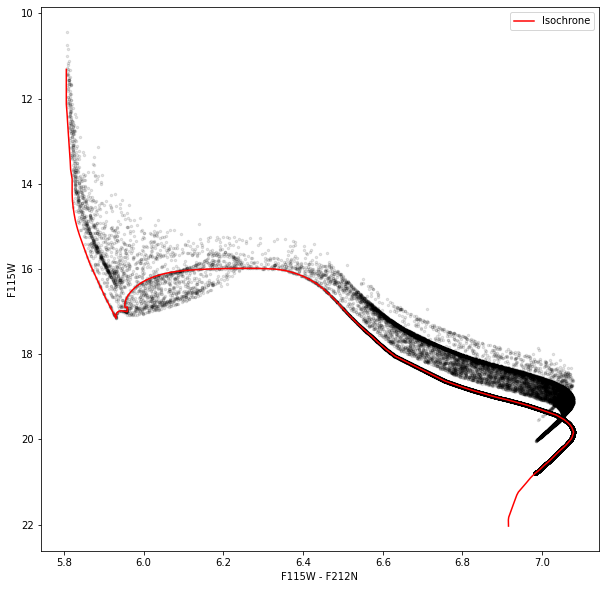

In [696]:
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_jwst_F115W'] - clust['m_jwst_F212N'], clust['m_jwst_F212N'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_jwst_F115W'] - iso['m_jwst_F212N'], iso['m_jwst_F212N'],
       'r-', label='Isochrone')
py.xlabel('F115W - F212N')
py.ylabel('F115W')
py.gca().invert_yaxis()
py.legend()

In [705]:
#creating isochrone object 
filt_list = ['jwst,F115W', 'jwst,F212N'] 
my_ifmr = ifmr.IFMR_Raithel18()
my_iso_young = synthetic.IsochronePhot(8, 0, 10,
                                 evo_model = evolution.MISTv1(),
                                      filters=filt_list)

my_iso_old = synthetic.IsochronePhot(10, 0, 10,
                                 evo_model = evolution.MISTv1(),
                                    filters=filt_list)

In [706]:
massLimits = np.array([0.1, 0.5, 120])
powers_kroupa = np.array([-1.3, -2.3])
powers_theavy = np.array([-1.3, -1.3]) # top heavy
trunc_kroupa = imf.IMF_broken_powerlaw(massLimits, powers_kroupa)
trunc_theavy = imf.IMF_broken_powerlaw(massLimits, powers_theavy)

In [707]:
# Make clusters                                                                                                                                                          
cluster_mass = 10**6
cluster_young_theavy = synthetic.ResolvedCluster(my_iso_young, trunc_theavy, cluster_mass, ifmr=my_ifmr)
cluster_old_theavy = synthetic.ResolvedCluster(my_iso_old, trunc_theavy, cluster_mass, ifmr=my_ifmr)
cluster_young_kroupa = synthetic.ResolvedCluster(my_iso_young, trunc_kroupa, cluster_mass, ifmr=my_ifmr)
cluster_old_kroupa = synthetic.ResolvedCluster(my_iso_old, trunc_kroupa, cluster_mass, ifmr=my_ifmr)

# Get the outputs
young_theavy = cluster_young_theavy.star_systems
old_theavy = cluster_old_theavy.star_systems
young_kroupa = cluster_young_kroupa.star_systems
old_kroupa = cluster_old_kroupa.star_systems

Found 26344 stars out of mass range
Found 468506 stars out of mass range


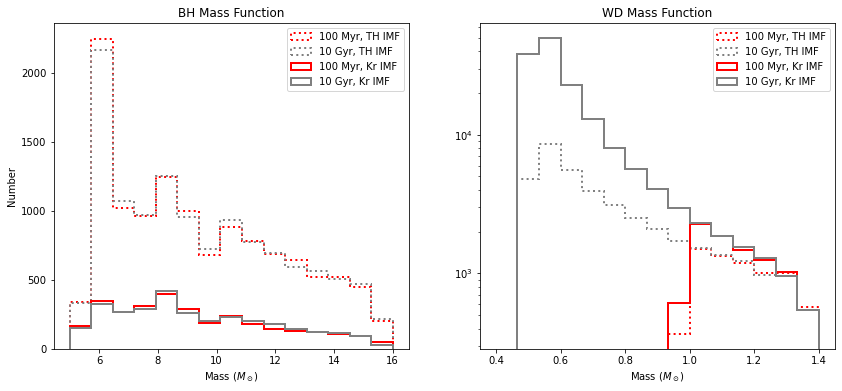

In [708]:
young_theavy_bh_idx = np.where(young_theavy['phase'] == 103)[0]
old_theavy_bh_idx = np.where(old_theavy['phase'] == 103)[0]
young_kroupa_bh_idx = np.where(young_kroupa['phase'] == 103)[0]
old_kroupa_bh_idx = np.where(old_kroupa['phase'] == 103)[0]

bh_bins = np.linspace(5, 16, 16)
wd_bins = np.linspace(0.4, 1.4, 16)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.hist(young_theavy[young_theavy_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '100 Myr, TH IMF', color = 'red', linestyle = ':', lw = 2)
plt.hist(old_theavy[old_theavy_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '10 Gyr, TH IMF', color = 'gray', linestyle = ':', lw = 2)
plt.hist(young_kroupa[young_kroupa_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '100 Myr, Kr IMF', color = 'red', lw = 2)
plt.hist(old_kroupa[old_kroupa_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '10 Gyr, Kr IMF', color = 'gray', lw = 2)
plt.title('BH Mass Function')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

young_theavy_wd_idx = np.where(young_theavy['phase'] == 101)[0]
old_theavy_wd_idx = np.where(old_theavy['phase'] == 101)[0]
young_kroupa_wd_idx = np.where(young_kroupa['phase'] == 101)[0]
old_kroupa_wd_idx = np.where(old_kroupa['phase'] == 101)[0]

plt.subplot(1, 2, 2)
plt.hist(young_theavy[young_theavy_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '100 Myr, TH IMF', color = 'red', linestyle = ':', lw = 2)
plt.hist(old_theavy[old_theavy_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '10 Gyr, TH IMF', color = 'gray', linestyle = ':', lw = 2)
plt.hist(young_kroupa[young_kroupa_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '100 Myr, Kr IMF', color = 'red', lw = 2)
plt.hist(old_kroupa[old_kroupa_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '10 Gyr, Kr IMF', color = 'gray', lw = 2)
plt.yscale('log')
plt.title('WD Mass Function')
plt.xlabel('Mass ($M_\odot$)')
plt.legend()